# Final Project Network Science #

# Agro-Food Trade Network #

## Loading dependencies

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
from statistics import mean
import sys
import os
import math
from itertools import chain

import scipy.sparse as sparse
from scipy.sparse import csr_matrix
from scipy.special import factorial

## Loading dataset

In [2]:
datafolder = r'C:/DS_UNIPD/2nd_year/Network science/FP_Network'
fields = ['yr', 'rt3ISO','pt3ISO','cmdCode','TradeValue']
df = pd.read_csv(datafolder + '/final_dataset.csv',
                 skipinitialspace = True, usecols = fields)
countries = pd.read_csv(datafolder + '/countries.csv') #,index_col = 'cc3')
comm_codes = pd.read_csv(datafolder + '/commodities.csv')

## Data Wrangling

In [3]:
countries.columns = ['lat' if x == 'latitude' else x for x in countries.columns]
countries.columns = ['lng' if x == 'longitude' else x for x in countries.columns]
countries['lat'] = countries['lat'].round(decimals = 2)
countries['lng'] = countries['lng'].round(decimals = 2)
df.columns = ['year' if x == 'yr' else x for x in df.columns]
df.columns = ['weight' if x == 'TradeValue' else x for x in df.columns]

In [4]:
# excluding aggregate regions
no_code_country = ['ANT', 'ATB', '_X ', 'A59', 'A79', 'E19', 'F19',
                   'O19', 'S19', 'W00', 'X1 ', 'X2 ', 'XX ', 'SCG']
for i in no_code_country:
  df.drop(df.index[df['pt3ISO'] == i], inplace=True)
  df.drop(df.index[df['rt3ISO'] == i], inplace=True)

# excluding tobacco as commodity
df.drop(df.index[df['cmdCode'] == 24], inplace=True)

df.isnull().values.any()

countries_rt = df['rt3ISO'].unique()
countries_rt.sort() # if some element is nan sort fails!
countries_pt = df['pt3ISO'].unique()
countries_pt.sort()
commodities = df['cmdCode'].unique()
periods = df['year'].unique()

In [5]:
print('Periods -> ', len(periods))
print('# of reporter countries -> ', len(countries_rt))
print('# of partner countries -> ', len(countries_pt))
print('# of commodities -> ',  len(commodities))

Periods ->  20
# of reporter countries ->  169
# of partner countries ->  234
# of commodities ->  23


## Build Trade Networks

Some useful functions

In [66]:
# Creating graphs by year -> format "G_[year]" or "G_[year]_[commodity]"

# adding node attributes
def node_attributes(G):
    ''' adding node attributes '''
    for node in G:
        for n, metadata in countries.set_index('cc3').iterrows():
            for key, val in metadata.items():
                if node == n:
                    G.nodes[node][key] = val
    return

def create_graph(year):
    ''' create directed graphs '''
    base_df = df[(df['year'] == year)] # & (df['cmdCode'] == com)]
    graphG = nx.from_pandas_edgelist(base_df, source = 'rt3ISO', target = 'pt3ISO',
                                edge_attr = ['year', 'cmdCode', 'weight'],
                                create_using = nx.DiGraph())
    node_attributes(graphG)
    return graphG

def create_ugraph(year):
    ''' create undirected graphs '''
    base_df = df[(df['year'] == year)] # & (df['cmdCode'] == com)]
    graphG = nx.from_pandas_edgelist(base_df, source = 'rt3ISO', target = 'pt3ISO',
                                edge_attr = ['year', 'cmdCode', 'weight'],
                                create_using = nx.Graph())
    node_attributes(graphG)
    return graphG

def create_graph2(year, com):
    ''' create directed graphs '''
    base_df = df[(df['year'] == year) & (df['cmdCode'] == com)]
    graphG = nx.from_pandas_edgelist(base_df, source = 'rt3ISO', target = 'pt3ISO',
                                edge_attr = ['year', 'cmdCode', 'weight'],
                                create_using = nx.DiGraph())
    node_attributes(graphG)
    return graphG

def print_net_stat(G):
    if G.is_directed():
        print('Directed Graph')
    else:
        print('Undirected Graph')
    N, K = G.order(), G.size()
    avg_deg= float(K) / N
    #print("Nodes: ", N)
    #print("Edges: ", K)
    print("Total number of nodes: ", int(G.number_of_nodes()))
    print("Total number of edges: ", int(G.number_of_edges()))
    print("Average degree: ", avg_deg)
    print("Density: ", nx.density(G))
    print('Total trade: ', G.size(weight="weight"))
    #print("Diameter: ", nx.diameter(G))
    if G.is_directed():
        print("if graph strongly connected ?? : ", nx.is_strongly_connected(G))
        print("if graph weakly connected ?? : ",nx.is_weakly_connected(G))
        print("SCC: ", nx.number_strongly_connected_components(G)) # not valid for UG type
        print("WCC: ", nx.number_weakly_connected_components(G))   # not valid for UG type
    else:
        print("Average Shortest Path Length: ", nx.average_shortest_path_length(G)) #valid for UG graph
    #print("List of all nodes: ", list(G.nodes()))
    #print("List of all edges: ", list(G.edges()))
    #print("In-degree for all nodes: ", dict(G.in_degree()))
    #print("Out degree for all nodes: ", dict(G.out_degree))
    print("Total number of self-loops: ", int(nx.number_of_selfloops(G)))
    print("List of all nodes with self-loops: ",
                 list(nx.nodes_with_selfloops(G)))
    return

def plot_adj_mtx(G):
    A = nx.adjacency_matrix(G) # returns A as SciPy sparse matrix
    kwargs = {'marker': 'o', 'alpha':0.5} #'cmap':'cmap.Blues'
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.spy(A, aspect = 'equal', origin='lower', markersize = 0.5, **kwargs)
    #plt.xlabel('Partners')
    #plt.ylabel('Partners')
    ax = plt.gca()
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.get_yaxis().set_tick_params(which='both', direction='out')
    ax.get_xaxis().set_tick_params(which='both', direction='out')
    #plt.axis('off')
    #plt.title("Food Trade Network - Adjacency Matrix", fontsize=12)
    return plt.show()

def plot_degDist_Hist(G):   
    aux1 = list(dict(nx.degree(G)).values())
    len(aux1)
    w = 10
    n = math.ceil((max(aux1) - min(aux1))/w)
    plt.subplots(figsize=(6,4))
    plt.hist(aux1, bins = n, facecolor = 'lightblue', edgecolor='k') #, alpha = 0.75)
    #plt.title("Degree Histogram")
    plt.xlabel('k, degree', fontsize=12)
    plt.ylabel('# of Nodes', fontsize=12)
    #plt.xlim(0, 500)
    #plt.ylim(0, 25)
    plt.grid(True)
    return plt.show()

def plotIn_OutDegDist(G, loglog = False, my_title = 'In / Out Degree distribution'):
    N, K = G.order(), G.size()
    avg_deg = float(K) / N
    
    od_sequence = sorted([d for n, d in G.out_degree()], reverse=True)  # degree sequence   
    o_degreeCount = Counter(od_sequence)
    od, cnt_1 = zip(*o_degreeCount.items())
    frac_1 = [n / G.number_of_nodes() for n in cnt_1]
    id_sequence = sorted([d for n, d in G.in_degree()], reverse=True)  # degree sequence
    i_degreeCount = Counter(id_sequence)
    id, cnt2 = zip(*i_degreeCount.items())
    frac_2 = [n / G.number_of_nodes() for n in cnt2]
    
    fig, ax = plt.subplots(figsize=(6,4))
    plt.title(my_title)
    if loglog:
        plt.loglog(od, frac_1, 'o', color = 'indigo', markersize = 4,
                   alpha = 0.9, label = '$k_{out}$')
        plt.loglog(id, frac_2, 'o', color = 'thistle', markersize = 4,
                   alpha = 0.9, label = '$k_{in}$')
    else:
        plt.plot(od, frac_1, 'o', color = 'indigo', markersize = 4,
                 alpha = 0.9, label = '$k_{out}$')
        plt.plot(id, frac_2, 'o', color = 'thistle', markersize = 4,
                 alpha = 0.9, label = '$k_{in}$')   
    #plt.grid(which='both', linestyle='--', linewidth=0.5)
    plt.ylabel('$p_{k}$', fontsize=14)
    plt.xlabel('$k_{in} , k_{out}$', fontsize=14)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_yaxis().set_tick_params(which='both', direction='in')
    ax.get_xaxis().set_tick_params(which='both', direction='in')
    ax.legend()
    return plt.show()

def geo_conversion(G, frame_x, frame_y):  
    scale_x = frame_x / 200 #260 # 360
    scale_y = frame_y / 40 #180
    pos_geo = {}
    for node in G.nodes():
        try:
            lt_1 = 90 + G.nodes[node]['lat']
        except KeyError:
            continue
        lg_1 = 180 + G.nodes[node]['lng']
        pos_geo[node] = (scale_x * lg_1, scale_y * lt_1)   
    return pos_geo

def plot_graph(G, frame_x, frame_y, mytitle = ''):
    pos_geo = geo_conversion(G, frame_x, frame_y)
    edges = list(set(G.edges()))
    arc_rad = 0.35
    fig, ax = plt.subplots(1, 1, figsize = (frame_x, frame_y))
    nx.draw_networkx_edges(G, pos = pos_geo, ax = ax, edgelist = edges,
                           connectionstyle = f'arc3, rad = {arc_rad}',
                           edge_color = 'lightblue', arrowstyle="->")
    nx.draw_networkx_nodes(G, pos = pos_geo, ax = ax,
                           node_color = 'lightgreen', node_size = 800)
    nx.draw_networkx_labels(G, pos = pos_geo, ax = ax)
    ax.set_title(mytitle, fontsize=60)
    return plt.show()

def summary_nodes(G):
    
    df_nodes_G = pd.DataFrame(index = G.nodes())
    df_nodes_G['country'] = pd.Series(nx.get_node_attributes(G, 'Country'))
    df_nodes_G['degree'] = pd.Series(dict(G.degree()))
    df_nodes_G['inDeg'] = pd.Series(dict(G.in_degree()))
    df_nodes_G['outDeg'] = pd.Series(dict(G.out_degree()))
    df_nodes_G['imports'] = pd.Series(dict(G.in_degree(weight='weight')))
    df_nodes_G['exports'] = pd.Series(dict(G.out_degree(weight='weight')))
    df_nodes_G['degCentNorm'] = pd.Series(nx.degree_centrality(G))
    df_nodes_G['indegCent'] = pd.Series(nx.in_degree_centrality(G))
    df_nodes_G['outdegCent'] = pd.Series(nx.out_degree_centrality(G))
    #df_nodes_G['eigenCent'] = pd.Series(nx.eigenvector_centrality(G, weight='weight'))
    df_nodes_G['betwenCent'] = pd.Series(nx.betweenness_centrality(G, k=None,
                                                                normalized=True, weight='weight'))
    df_nodes_G['closeCent'] = pd.Series(nx.closeness_centrality(G))
    df_nodes_G['pageRank'] = pd.Series(nx.pagerank(G, alpha=0.85))

    return df_nodes_G

def summary_nodes_ug(G):
    
    df_nodes_G = pd.DataFrame(index = G.nodes())
    df_nodes_G['country'] = pd.Series(nx.get_node_attributes(G, 'Country'))
    df_nodes_G['degree'] = pd.Series(dict(G.degree()))
    df_nodes_G['imports'] = pd.Series(dict(G.degree(weight='weight')))
    df_nodes_G['degCentNorm'] = pd.Series(nx.degree_centrality(G))
    df_nodes_G['closeCent'] = pd.Series(nx.closeness_centrality(G))
    df_nodes_G['pageRank'] = pd.Series(nx.pagerank(G, alpha=0.85))

    return df_nodes_G

def log_binned(d, nbins):
    kmax = np.max(d)
    end = np.rint(np.log10(kmax))
    bins = np.logspace(0, end, nbins)
    # Computing histogram and bins middle points
    hist = np.histogram(d, bins = bins, density=True)
    logbin_p_k = hist[0]
    middle_bins = np.sqrt(np.delete(bins, 0) * np.delete(bins, nbins-1))
    return middle_bins, logbin_p_k

def plot_powerlaw(G, type_deg, kmin):
    # 0 : out degree, 1 : in degree
    #N, K = G.order(), G.size()
    
    if type_deg == 0:
        d = sorted([d for n, d in G.out_degree()], reverse=True)  # degree sequence  
    else:
        d = sorted([d for n, d in G.in_degree()], reverse=True)  # degree sequence  
    
    d = np.asarray(d)
    d = d[d > 0]   # avoid zero degree nodes
    
    sorted_od = sorted(d)
    occurrence = Counter(sorted_od)
    k = list(Counter(occurrence).keys())     
    p_k = list(Counter(occurrence).values()) 
    p_k = p_k/np.sum(p_k)
    
    Pk = 1 - np.cumsum(p_k)     # complementary cumulative
    Pk[-1] = 1
    Pk = sorted(Pk, reverse = True)
    
    # Power-law -> Max Likelihood calculation method for gamma
    d2 = d[d > kmin]                             # restrict range
    ML_gamma = 1 + 1 / (np.mean(np.log(d2 / kmin)))  # computing gamma
    C = (ML_gamma-1)*kmin**(ML_gamma-1) # normalization condition
    pos = np.argmax(np.array(k) >= kmin)
    P_kmin = Pk[pos] # constant value that shifts the line where the data are placed
    # degree distribution follows the power law
    pk = C * P_kmin * k ** -ML_gamma 
    # CCDF 
    Pk_est = C * P_kmin * k ** (-(ML_gamma - 1)) / (ML_gamma - 1)
    
    # Power-law -> gamma calculation using numpy polifit
    # dd polyfit
    logx = np.log(k)
    logy = np.log(p_k)
    m, q = np.polyfit(logx, logy, 1) #slope and intercept of the fitting line
    yfit = np.exp(m * logx + q)
    # CCDF polyfit
    logPk = np.log(Pk)
    m_Pk, q_Pk = np.polyfit(logx, logPk, 1) #slope and intercept of the fitting line
    Pkfit = np.exp(m_Pk * logx + q_Pk)
    
    nbins = 16
    k_mid_bin, logbin_p_k = log_binned(d, nbins)
    
    # considering k > kmin
    exp = np.log10(kmin)
    mask = np.log10(k_mid_bin) > exp
    x_b = np.log10(k_mid_bin[mask])
    y_b = np.log10(logbin_p_k[mask])
    # Linear fit
    params = np.polyfit(x_b, y_b, deg = 1)
    lin_gamma = -params[0]
    x2 = np.logspace(exp, 3, 100)
    y2 = np.full(100, 10**(params[1]) * x2 ** (-lin_gamma)) 
    
    plt.figure(figsize=(60, 60))
    plt.subplot(8, 6, 1)
    
    plt.loglog(k, p_k, 'o', color = 'tab:blue', markersize = 4, label='data')
    plt.loglog(k, pk, linestyle="--", color = 'tab:red', label = 'ML fit, $\gamma$ = ' + str(np.round(-ML_gamma, 2)))
    plt.loglog(k, yfit, color='tab:olive', linestyle='--', label = 'polyfit, $\gamma$ = ' + str(np.round(m, 2)))
    plt.vlines(x=kmin, ymin=0, ymax=len(p_k), colors = 'gray', ls=':', lw=2, label='$k_{min}$ = '+str(kmin))
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    if type_deg == 0:
        plt.title(" OUT Degree Distribution", size = 20)
        plt.xlabel('$k_{out}$', size = 18)
    else:
        plt.title("IN Degree Distribution", size = 20)
        plt.xlabel('$k_{in}$', size = 18)
    plt.ylabel('$p_{k}$', size = 18)
    plt.legend()
    
    plt.subplot(8, 6, 2)
    
    plt.loglog(k, p_k, 'o', color = 'tab:blue', markersize = 4, label = 'data')
    plt.loglog(k_mid_bin, logbin_p_k, 'D', markerfacecolor = 'cyan',
               markeredgecolor = 'tab:blue', label = 'log-binned')
    plt.plot(x2, y2, label = 'linear fit, $\gamma$ = ' + str(np.round(lin_gamma, 2)),
             color="tab:olive", linestyle="--")
    plt.vlines(x=kmin, ymin=0, ymax=len(p_k), colors = 'gray', ls=':', lw=2, label='$k_{min}$ = '+str(kmin))
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    if type_deg == 0:
        plt.title(" OUT Log-binning Degree Distribution", size = 20)
        plt.xlabel('$k_{out}$', size = 18)
    else:
        plt.title("IN Log-binning Degree Distribution", size = 20)
        plt.xlabel('$k_{in}$', size = 18)
    plt.ylabel('$p_{k}$', size = 18)
    plt.legend()
    
    plt.subplot(8, 6, 3)
    
    plt.loglog(k, Pk, 'o', color = 'tab:blue', markersize = 4, label = 'CCDF data')
    plt.loglog(k, Pk_est, color = 'tab:red', linestyle='--', label = 'ML fit, $\gamma$ = ' + str(np.round(-ML_gamma, 2)))
    plt.loglog(k, Pkfit, color = 'tab:olive', linestyle='--', label = 'polyfit, $\gamma$ = ' + str(np.round(m_Pk-1, 2)))
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    if type_deg == 0:
        plt.title('OUT CCDF', size = 20)
        plt.xlabel('$k_{out}$', size = 18)
    else:
        plt.title('IN CCDF', size = 20)
        plt.xlabel('$k_{in}$', size = 18)
    plt.legend()
    plt.ylabel('$P_{k}$', size = 18)
    return plt.show()

Generate graphs

In [23]:
G_2012_1 = create_graph2(2012, 1)
G_2013_1 = create_graph2(2013, 1)
G_2014_1 = create_graph2(2014, 1)
G_2015_1 = create_graph2(2015, 1)

Generating nodes attributes

In [24]:
# print_net_stat(G_2012_1)
# print_net_stat(G_2013_1)
# print_net_stat(G_2014_1)
print_net_stat(G_2015_1)

Directed Graph
Total number of nodes:  194
Total number of edges:  3922
Average degree:  20.216494845360824
Density:  0.10474867795523743
Total trade:  20868153315.0
if graph strongly connected ?? :  False
if graph weakly connected ?? :  True
SCC:  37
WCC:  1
Total number of self-loops:  0
List of all nodes with self-loops:  []


Adjacency Matrix of WTN livestock commodity, 2015

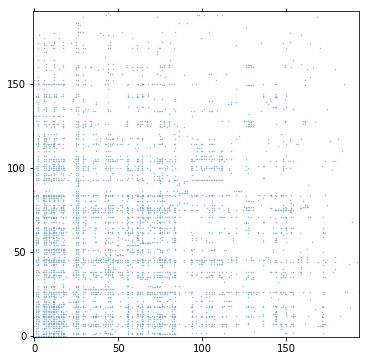

In [25]:
plot_adj_mtx(G_2015_1)

Degree Distribution of WTN 2015 livestock

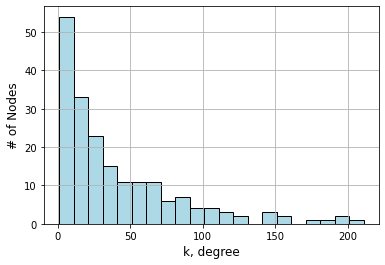

In [26]:
# plot_degDist_Hist(G_2012_1)
# plot_degDist_Hist(G_2013_1)
# plot_degDist_Hist(G_2014_1)
plot_degDist_Hist(G_2015_1)

Plot In-Out degree distribution in log-log scale

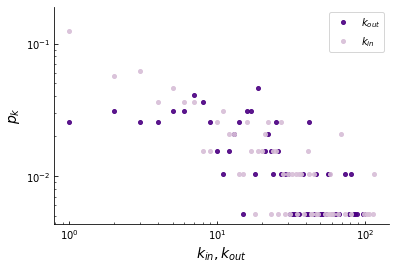

In [16]:
# plotIn_OutDegDist(G_2012_1, loglog = True, my_title = '')
# plotIn_OutDegDist(G_2013_1, loglog = True, my_title = '')
# plotIn_OutDegDist(G_2014_1, loglog = True, my_title = '')
plotIn_OutDegDist(G_2015_1, loglog = True, my_title = '')

Visualizing Network

In [67]:
frame_x = 50
frame_y = 40
pos_geo = geo_conversion(G_2015_1, frame_x, frame_y)

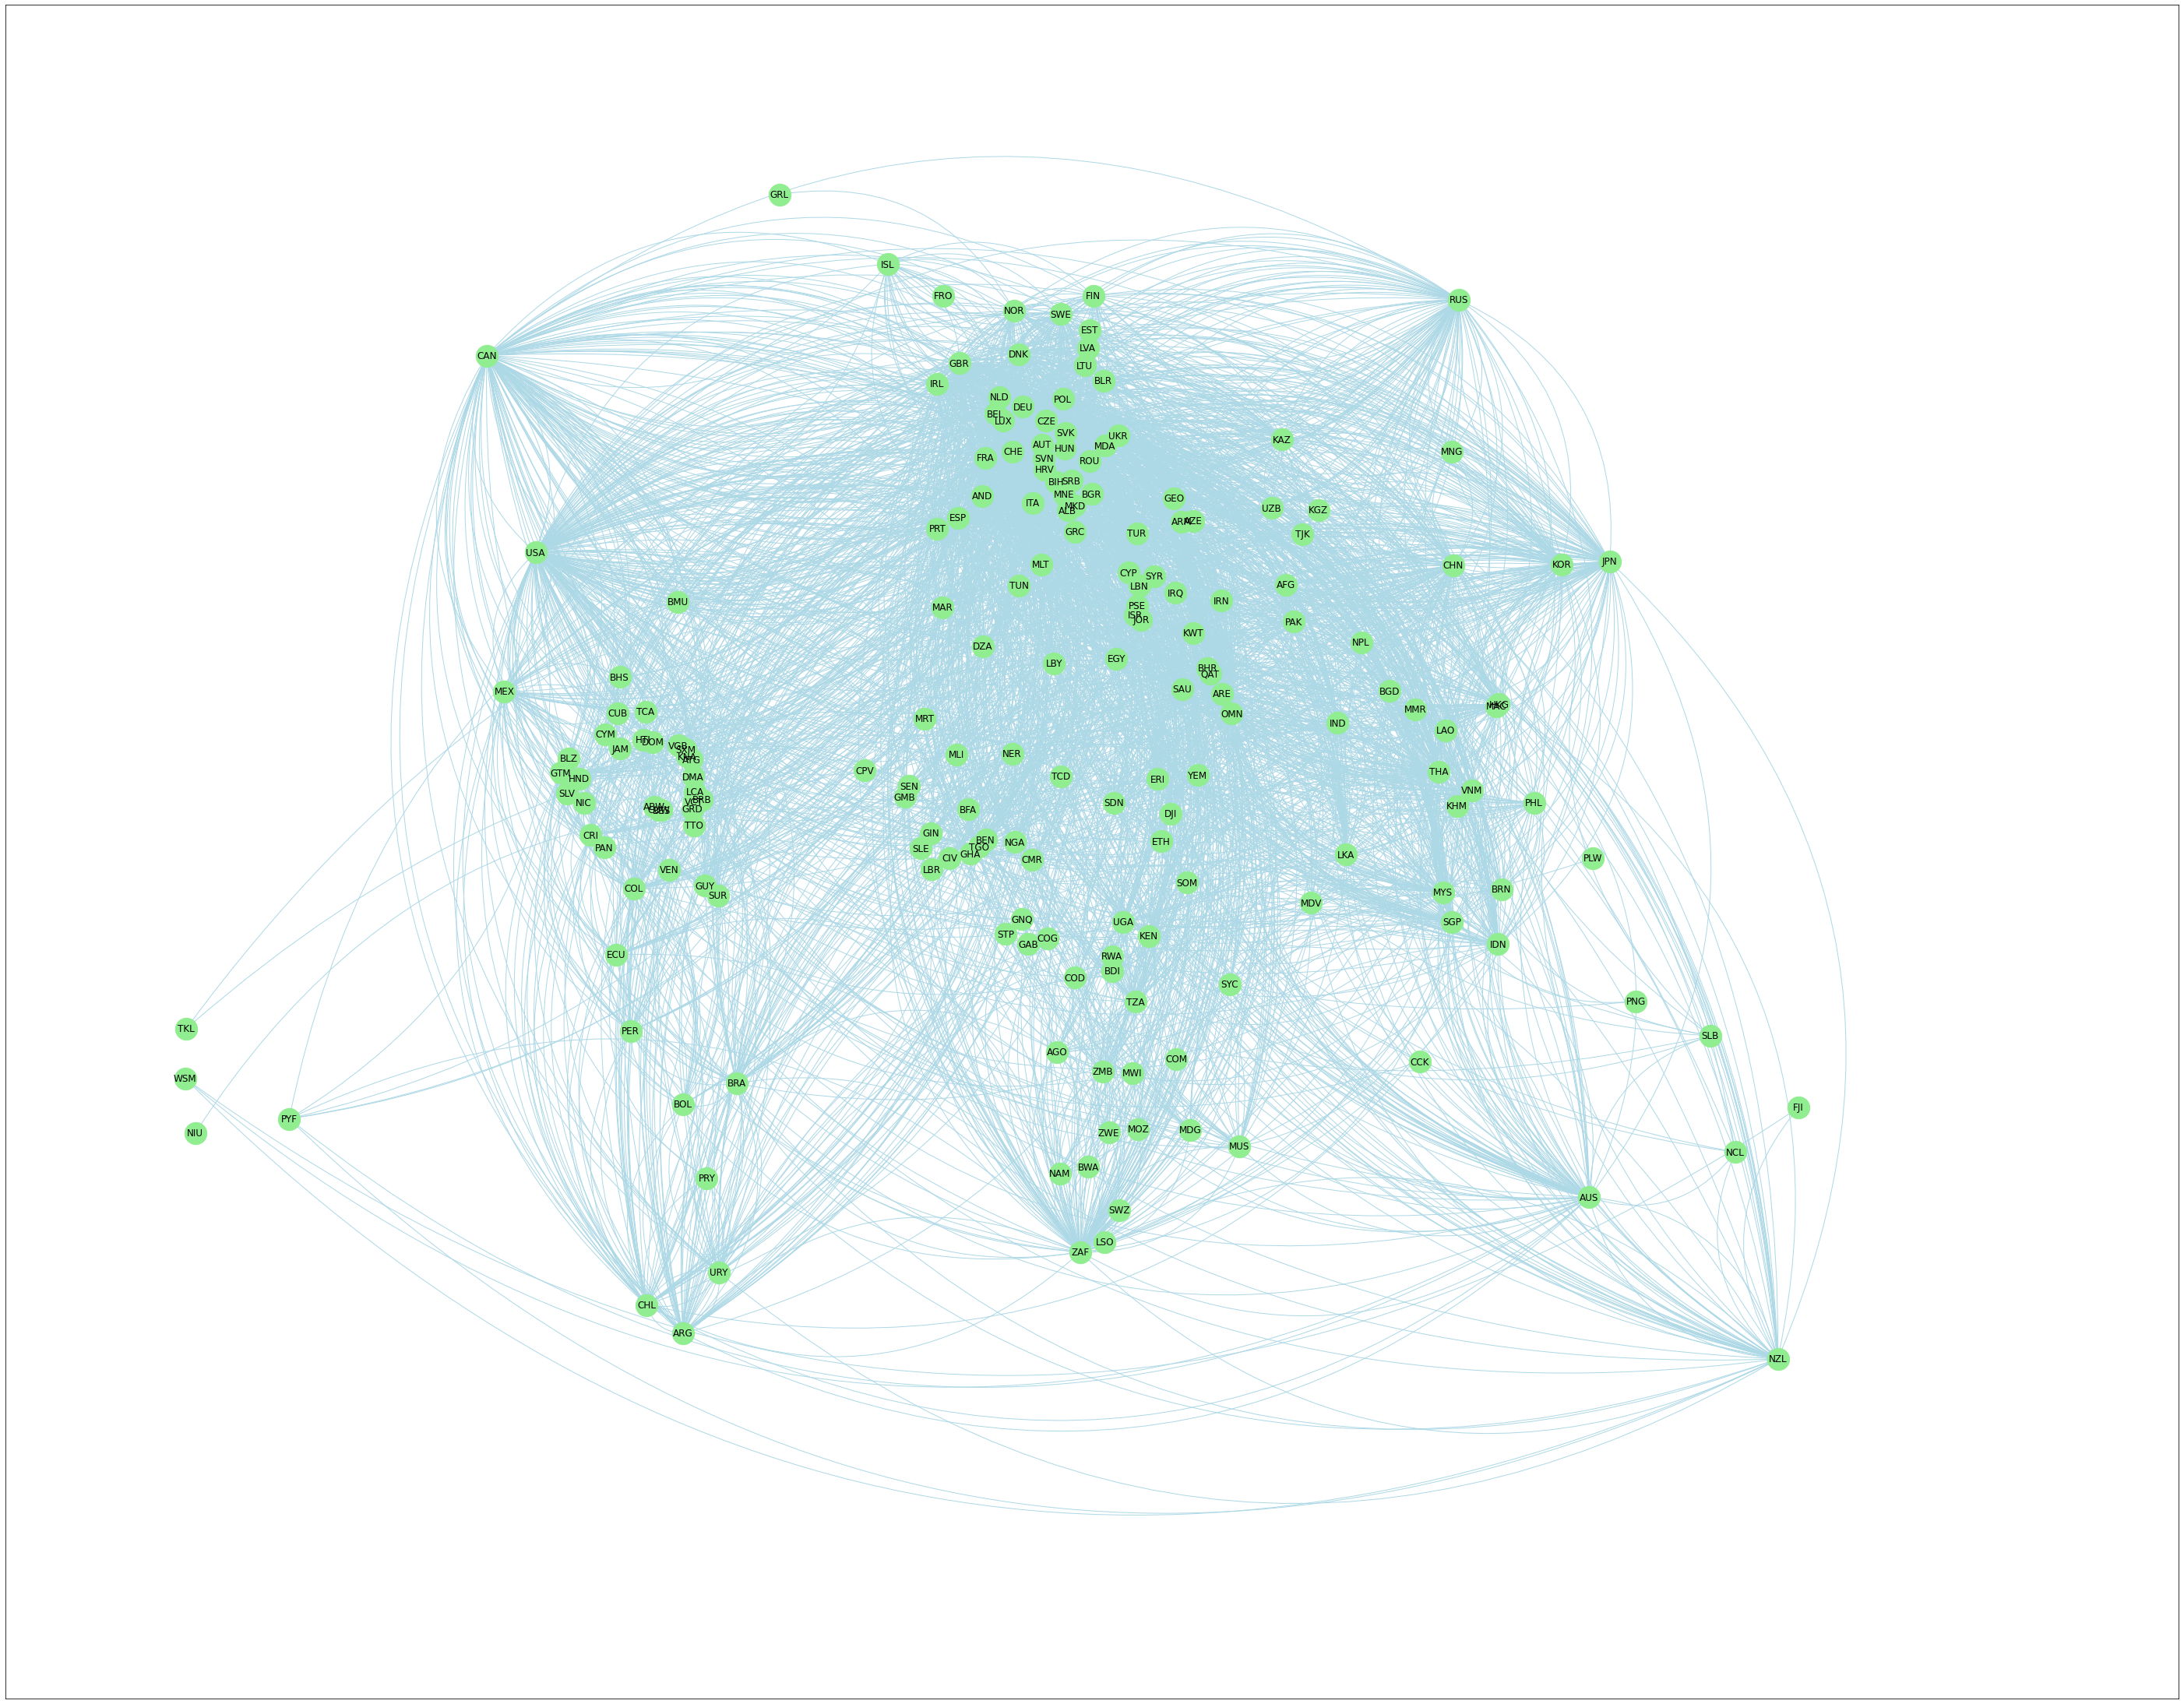

In [69]:
plot_graph(G_2015_1, frame_x, frame_y, mytitle = '')

Exporting graphs to Gephi file format

In [28]:
nx.write_gexf(G_2012_1, datafolder + '/G_2012_1.gexf', version="1.2draft")
nx.write_gexf(G_2013_1, datafolder + '/G_2013_1.gexf', version="1.2draft")
nx.write_gexf(G_2014_1, datafolder + '/G_2014_1.gexf', version="1.2draft")
nx.write_gexf(G_2015_1, datafolder + '/G_2015_1.gexf', version="1.2draft")

Saving network properties in CSV file format

In [30]:
df_nodes_G_2012_1 = summary_nodes(G_2012_1)
df_nodes_G_2012_1.to_csv (datafolder + '/df_nodes_G_2012_1.csv', index = False, header=True)

df_nodes_G_2013_1 = summary_nodes(G_2013_1)
df_nodes_G_2013_1.to_csv (datafolder + '/df_nodes_G_2013_1.csv', index = False, header=True)

df_nodes_G_2014_1 = summary_nodes(G_2014_1)
df_nodes_G_2014_1.to_csv (datafolder + '/df_nodes_G_2014_1.csv', index = False, header=True)

df_nodes_G_2015_1 = summary_nodes(G_2015_1)
df_nodes_G_2015_1.to_csv (datafolder + '/df_nodes_G_2015_1.csv', index = False, header=True)

Estimating $\gamma$ parameter and fit power-law

WTN 2012, 1

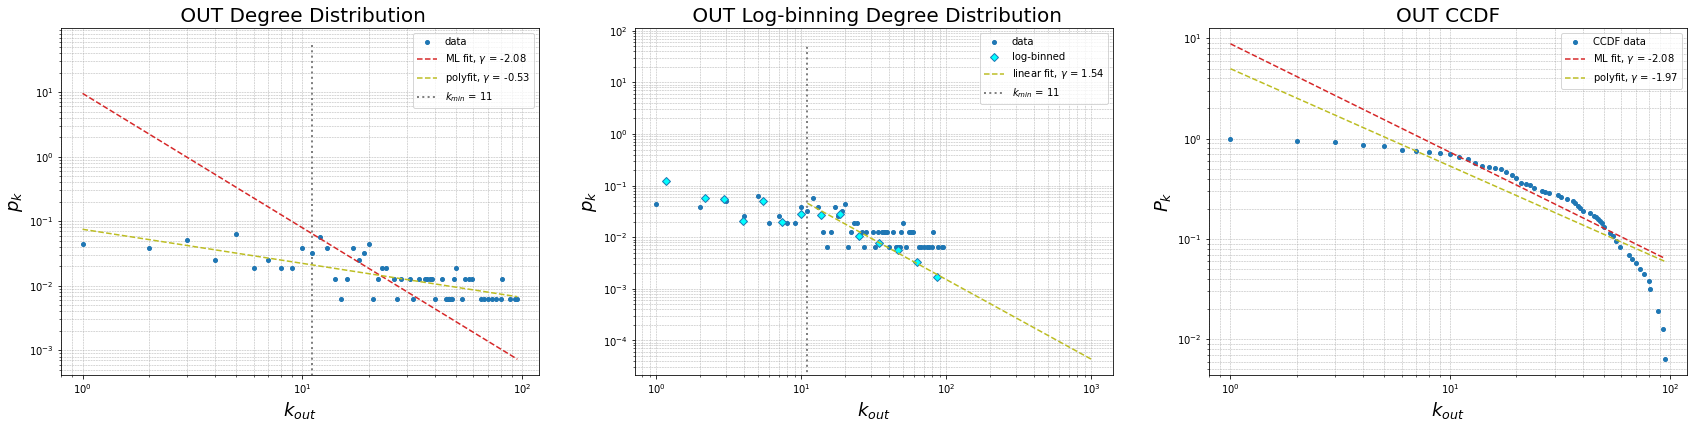

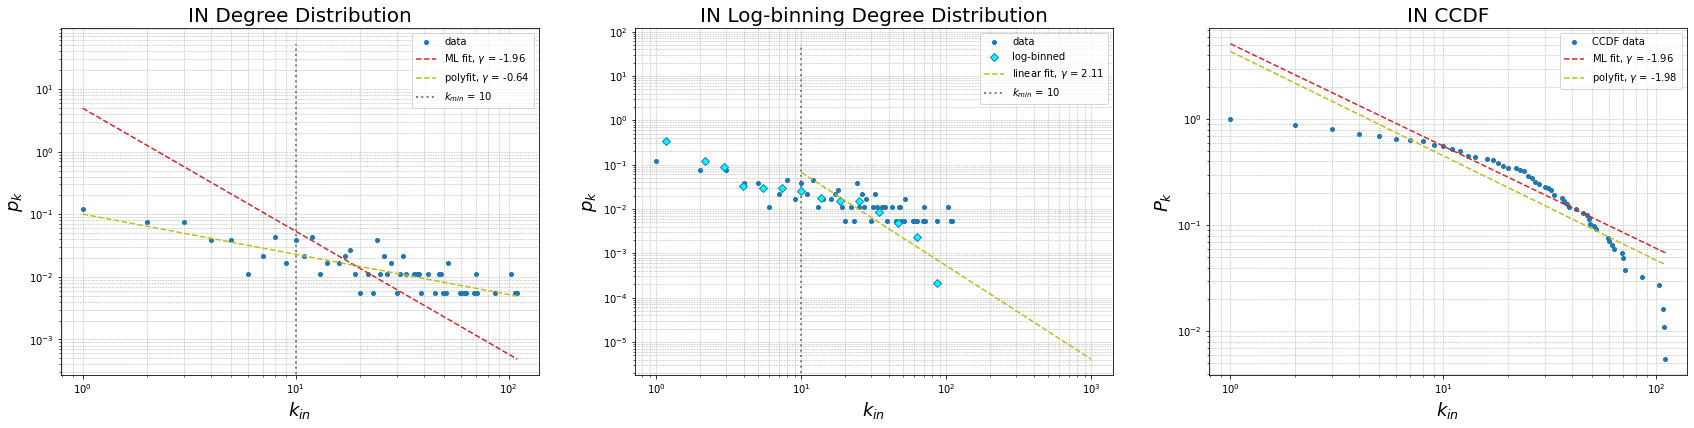

In [41]:
kmin_out = 11
kmin_in = 10
plot_powerlaw(G_2012_1, 0, kmin_out)
plot_powerlaw(G_2012_1, 1, kmin_in)

WTN 2013, 1

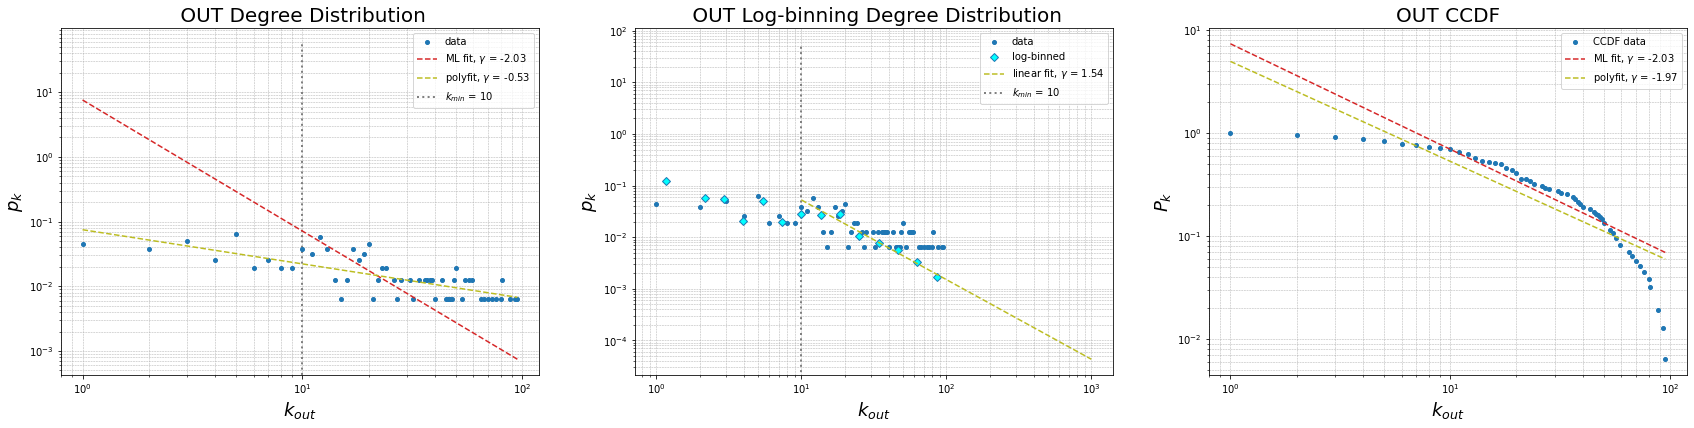

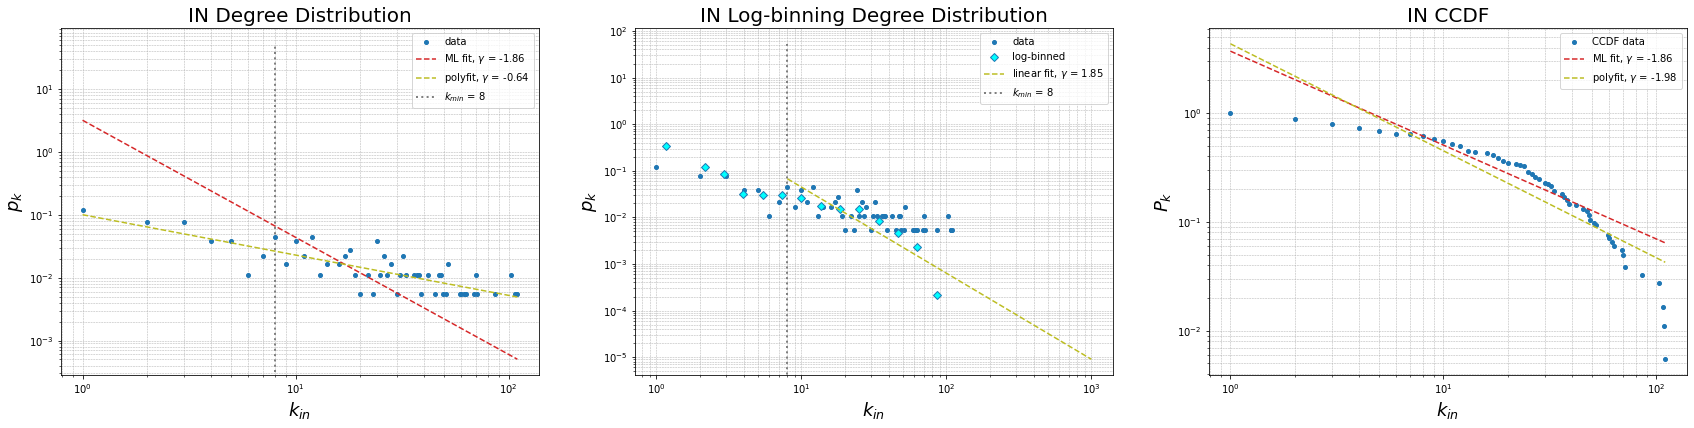

In [39]:
kmin_out = 10
kmin_in = 8
plot_powerlaw(G_2013_1, 0, kmin_out)
plot_powerlaw(G_2013_1, 1, kmin_in)

WTN 2014, 1

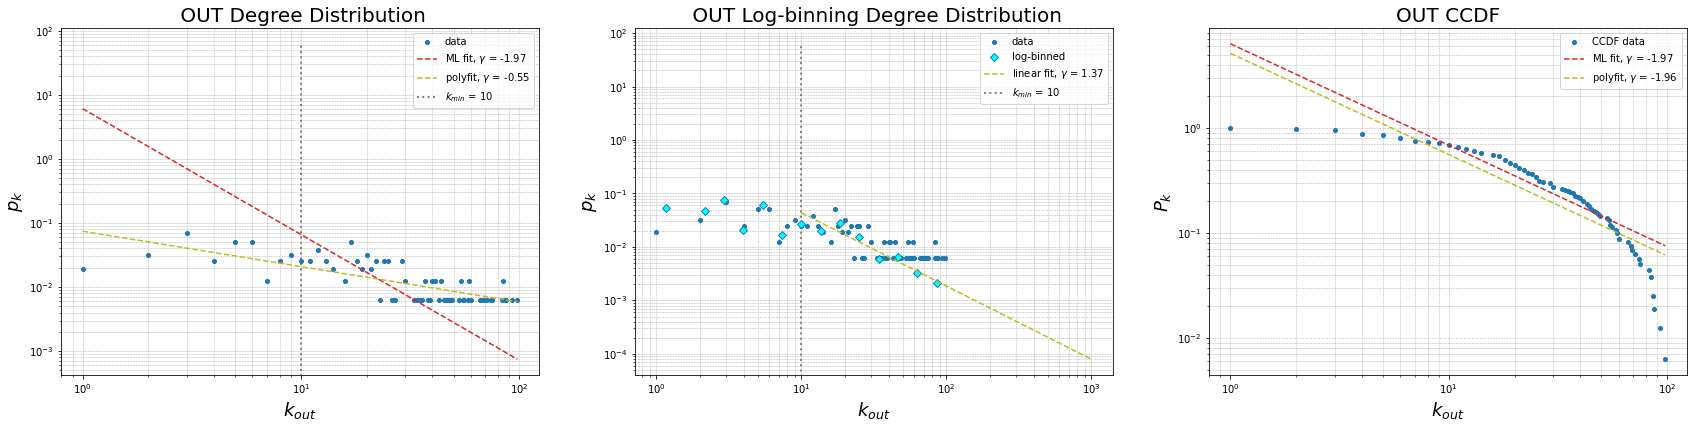

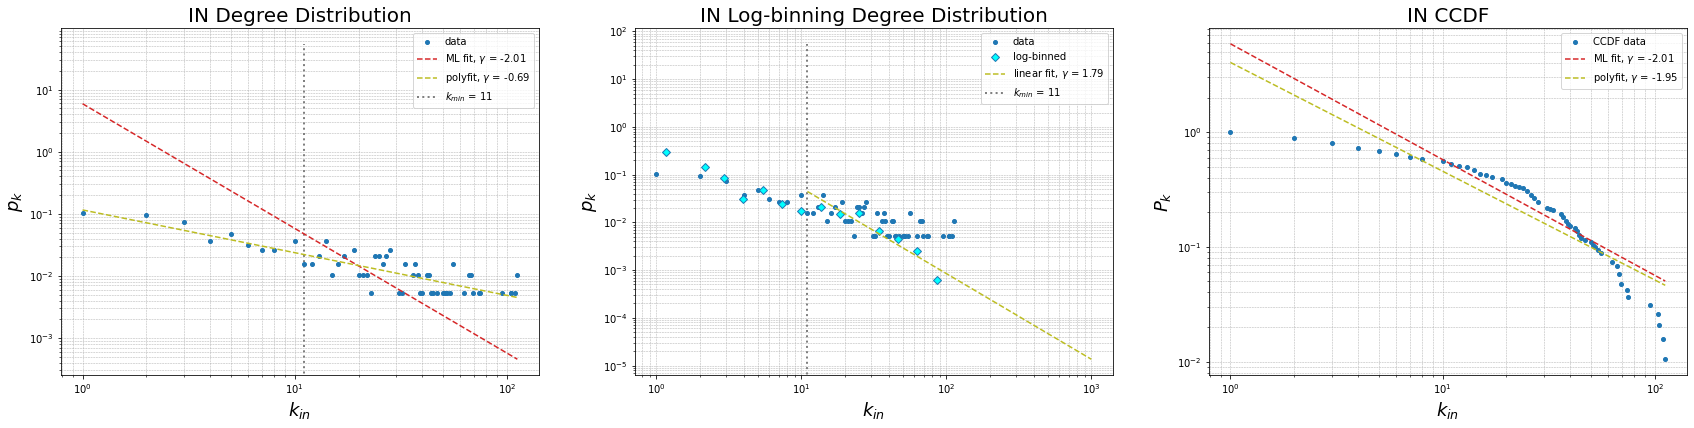

In [51]:
kmin_out = 10
kmin_in = 11
plot_powerlaw(G_2014_1, 0, kmin_out)
plot_powerlaw(G_2014_1, 1, kmin_in)

WTN 2015, 1

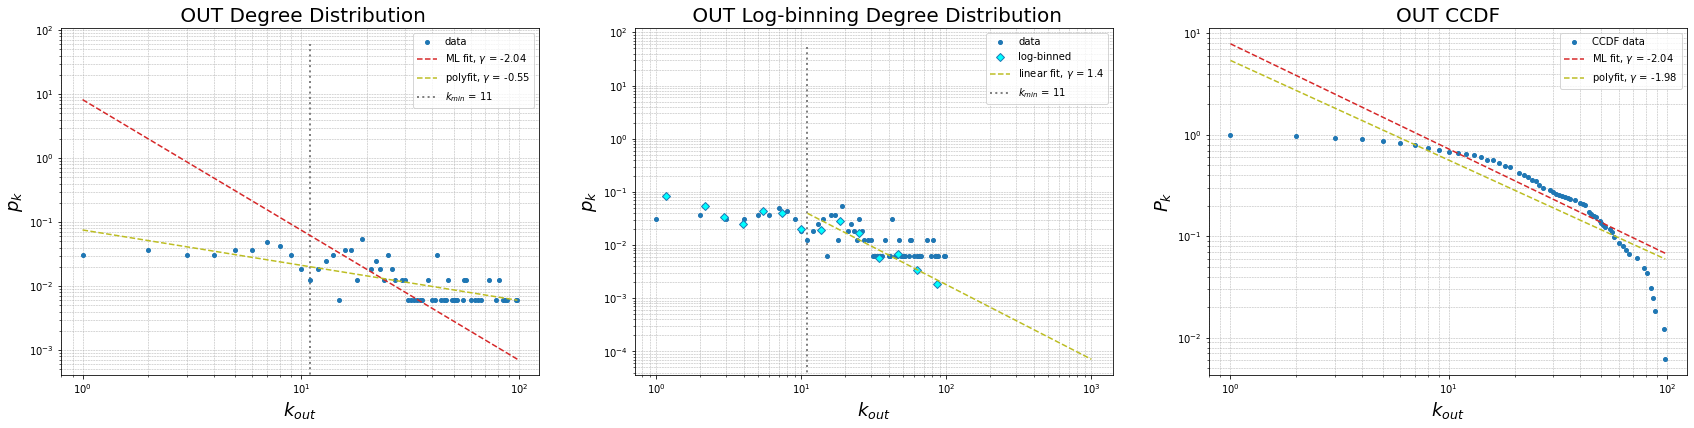

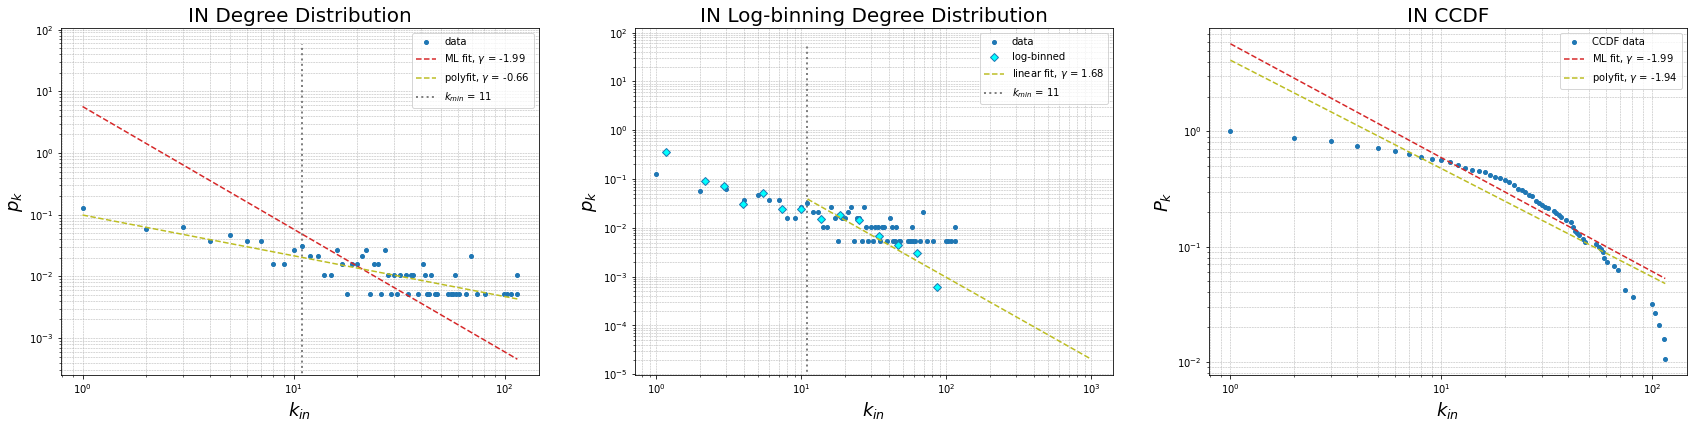

In [53]:
kmin_out = 11
kmin_in = 11
plot_powerlaw(G_2015_1, 0, kmin_out)
plot_powerlaw(G_2015_1, 1, kmin_in)